# Trabalho 2
### by Lucas de Jesus B. Gonçalves

In [1]:
import torch
import torch.functional as F
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060 SUPER'

### Dataset

In [3]:
# gera os dados segundo o trabalho
def datagen(qtd_amostras = 500):
    #parâmetros de inicialização
    beta, gamma = 0.4, 0.2 #Não mudar
    n, tau = 18, 20 #Não mudar
    
    x = tau*[0]
    x.append(1)
    for _ in range(0,qtd_amostras):
        xt = x[-1]+(beta*x[-tau]/(1+x[-tau]**n))-gamma*x[-1]
        x.append(xt)
        
    return x[tau+1:]
    
class TSDataset(Dataset):
    def __init__(self, data, step_ahead):
        self.step_ahead = step_ahead
        self.data=torch.tensor(data, dtype=torch.float32)

    #------------metodos sobrecarregados de Dataset-----------------
    def __getitem__(self, index):
        x = self.data[index: index + self.step_ahead]
        y = self.data[index + step_ahead]
        return x, y
        
    def __len__(self):
        return len(self.data) - self.step_ahead

### Modelo

In [4]:
class MeuModelo(nn.Module):
    def __init__(self, step_ahead):
        
        #chama o construtor da superclasse
        super().__init__()

        drate = 0.05

        self.layer0 = nn.Sequential(
            nn.Linear(step_ahead, 64), 
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(drate),
        )

        self.layer1 = nn.Sequential(
            nn.Linear(64, 64), 
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(drate/2),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32), 
            nn.BatchNorm1d(32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(drate/4),
        )
        
        self.out =  nn.Linear(32, 1)
    

        #chama função de inicialização dos pesos
        self.init_weights()

    
    def forward(self, x):
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
      
        return x

    
    
    #inicializa pesos com inicialização kaiming (melhor q xavier para relu)
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a= 0.01, nonlinearity='leaky_relu') #para evitar problemas com relu
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    

    def treinar(self, train_loader, val_loader, num_epochs, cost_function, optimizer, scheduler = None, verbose=True):
        
        # Dispositivo para o processamento
        device = next(self.parameters()).device

        #ativa o autotuner do cuDNN = + performace
        torch.backends.cudnn.benchmark = True

        #ativa scaler para quando o gradiente é muito pequeno quando usando fp16
        scaler = torch.cuda.amp.GradScaler()

        #otimização gpu
        use_amp = True
        #-----------------------------------------------------------------------
    
        
        loss_history = {"train": [], "val":[]}
        learning_rates = []

        for epoch in range(num_epochs):
    
            # Loss acumulada para o treino
            acum_train_loss = 0
            acum_val_loss = 0

            #define como treino
            self.train()
            
            # loop para cada batch
            for batch_index, (train_x, train_y) in enumerate(train_loader):

                 # Carrega os dados no dispositivo (GPU)
                train_x = train_x.to(device, non_blocking=True)
                train_y = train_y.to(device, non_blocking=True).unsqueeze(1)
                
                #Roda o foward com autocast para aproveitar do boost fp16 dos tensorcores
                with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                   
                    train_output = self(train_x)
                    train_loss = cost_function(train_output, train_y)

        
                # faz update da loss acumulada
                acum_train_loss += train_loss.item()
                
                # Backward e update
                # Zera o gradiente para evitar BO (set to none = + desempenho)
                optimizer.zero_grad(set_to_none=True)    

                #aplica escala na loss e aplica o backward
                scaler.scale(train_loss).backward()

                #se tiver algum NaN ou inf, optimizer.step() não é executado
                scaler.step(optimizer)

                #atualiza o scaler para a proxima iteração
                scaler.update()
    
            # Validação
            self.eval()
            
            # Não precisa calcular gradiente para a validação
            with torch.no_grad():  
                for batch_index, (val_x, val_y) in enumerate(val_loader):

                    val_x = val_x.to(device, non_blocking=True)
                    val_y = val_y.to(device, non_blocking=True).unsqueeze(1)

                    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                        val_output = self(val_x)
                        val_loss = cost_function(val_output, val_y)
                        
                    acum_val_loss += val_loss.item()
    
            # Calcula as metricas para a epoca
            epoch_train_loss = acum_train_loss / len(train_loader)
            epoch_val_loss = acum_val_loss / len(val_loader)
            

            #atualiza o scheduller
            if scheduler is not None:
                #atualiza a lr
                lr_antiga = optimizer.param_groups[0]["lr"]
                scheduler.step(epoch_val_loss)
                lr_nova = optimizer.param_groups[0]["lr"]


            learning_rates.append(optimizer.param_groups[0]["lr"])
            
            # Salva a loss e a acuracia de treino e validação
            loss_history["train"].append(epoch_train_loss)
            loss_history["val"].append(epoch_val_loss)
    
            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs} > Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        return loss_history, learning_rates

### Treinamento

In [5]:
data =  datagen(qtd_amostras = 5000)

# Faz o split do dataset em treino e validação
split_index = int(len(data) * 0.9)
train_data = data[:split_index]
val_data = data[split_index:]

#cria os objetos do tipo dataset
step_ahead = 64
train_ds = TSDataset(train_data, step_ahead)
val_ds = TSDataset(val_data, step_ahead)

#cria os dataloaders
train_loader = DataLoader(train_ds, batch_size=256, pin_memory=True, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, pin_memory=True, shuffle=False, num_workers=2)

In [6]:
import torch.optim.lr_scheduler as lr_scheduler

#verifica se tem gpu disponível e configura automaticamente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#cria o modelo e o atribui para o melhor dispositivo encontrado

#modelo baseado no resnet
modelo = MeuModelo(step_ahead).to(device, non_blocking=True)

#configuração do otimizador: melhor 5e-4 (val loss 0.0022)
learning_rate = 5e-4

# melhor 0.0005 (val loss 0.0022)
decay = 0.0005

#configuração epocas
epochs = 200

#optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate, weight_decay = decay, fused=True)
optimizer = torch.optim.AdamW(modelo.parameters(), lr=learning_rate, weight_decay = decay, fused=True)

#scheduler = None
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.618, patience=30, threshold=1e-2, threshold_mode='abs')
#scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, div_factor= 30, steps_per_epoch=1, epochs=epochs)
#scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr = 0.01, step_size_up = 15, step_size_down=25, mode="triangular2")
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=epochs)

#função de loss
cost = nn.MSELoss()

In [7]:
summary(modelo, input_size=(step_ahead,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           4,160
       BatchNorm1d-2                   [-1, 64]             128
         LeakyReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
       BatchNorm1d-6                   [-1, 64]             128
         LeakyReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
      BatchNorm1d-10                   [-1, 32]              64
        LeakyReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                    [-1, 1]              33
Total params: 10,753
Trainable params: 

In [8]:
hist, learning_rates = modelo.treinar(train_loader, val_loader,  epochs, cost, optimizer, scheduler=scheduler, verbose=True)

Epoch 1/200 > Train Loss: 0.6528, Val Loss: 0.1210
Epoch 2/200 > Train Loss: 0.2365, Val Loss: 0.0783
Epoch 3/200 > Train Loss: 0.1711, Val Loss: 0.0642
Epoch 4/200 > Train Loss: 0.1377, Val Loss: 0.0492
Epoch 5/200 > Train Loss: 0.1192, Val Loss: 0.0404
Epoch 6/200 > Train Loss: 0.1063, Val Loss: 0.0335
Epoch 7/200 > Train Loss: 0.0979, Val Loss: 0.0282
Epoch 8/200 > Train Loss: 0.0873, Val Loss: 0.0245
Epoch 9/200 > Train Loss: 0.0780, Val Loss: 0.0228
Epoch 10/200 > Train Loss: 0.0707, Val Loss: 0.0201
Epoch 11/200 > Train Loss: 0.0671, Val Loss: 0.0184
Epoch 12/200 > Train Loss: 0.0642, Val Loss: 0.0167
Epoch 13/200 > Train Loss: 0.0615, Val Loss: 0.0161
Epoch 14/200 > Train Loss: 0.0565, Val Loss: 0.0149
Epoch 15/200 > Train Loss: 0.0555, Val Loss: 0.0136
Epoch 16/200 > Train Loss: 0.0503, Val Loss: 0.0129
Epoch 17/200 > Train Loss: 0.0514, Val Loss: 0.0123
Epoch 18/200 > Train Loss: 0.0493, Val Loss: 0.0120
Epoch 19/200 > Train Loss: 0.0453, Val Loss: 0.0115
Epoch 20/200 > Train 

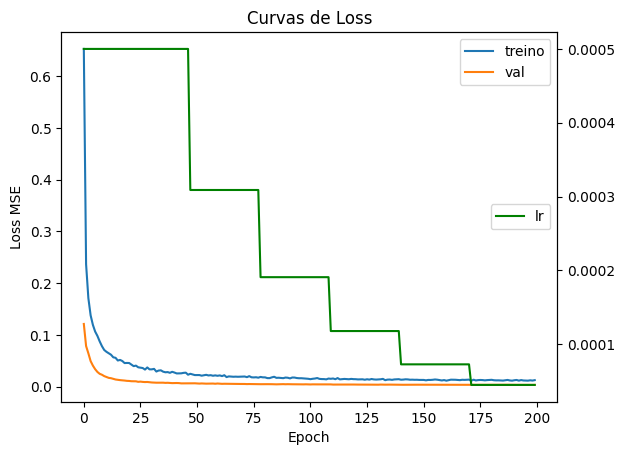

In [9]:
fig, ax1 = plt.subplots()
ax1.plot(hist["train"], label="treino")
ax1.plot(hist["val"], label="val")

ax1.set_xlabel("Epoch") 
ax1.set_ylabel("Loss MSE") 
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(learning_rates, 'g-', label="lr")
ax2.legend(loc='center right')

plt.title("Curvas de Loss") 
plt.show()

In [10]:
#torch.save(modelo, "/home/lucas/mestrado/RNP-Trabalho2/modelo1")

In [11]:
m = torch.load("/home/lucas/mestrado/RNP-Trabalho2/modelo1")
m = m.to(device, non_blocking=True)

In [12]:
def print_recursive(modelo, dados, instante, step_ahead):
    # Dispositivo para o processamento
    device = next(modelo.parameters()).device

    #ativa o autotuner do cuDNN = + performace
    torch.backends.cudnn.benchmark = True

    #otimização gpu
    use_amp = True
    
    len_dados = len(dados)
    history = torch.tensor(dados[:instante], dtype=torch.float32)

    # Não precisa calcular gradiente 
    modelo.eval()
    with torch.no_grad():  
        for _ in range(instante, len_dados):

            # pega os ultimos dados como entrada
            x = history[-step_ahead:]
            x = x.to(device, non_blocking=True).unsqueeze(0)

            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                y = modelo(x)

            #concatena a nova predição
            history = torch.cat((history, y.cpu().flatten()), dim=0) 

    plt.figure(figsize=(12, 6))
    plt.plot(dados, color="g", label="original")
    plt.plot(range(instante, len_dados), history[instante:], color="b", label="predito")
    plt.axvline(x=instante, color='r', linestyle='--')
    
    plt.xlabel("tempo") 
    plt.ylabel("Valores") 
    plt.title("Predição recursiva") 
    plt.legend()
    plt.show()

    #retorna os dados original e predito a partir do instante de predição
    return np.array(dados[instante:]), history[instante:].numpy()

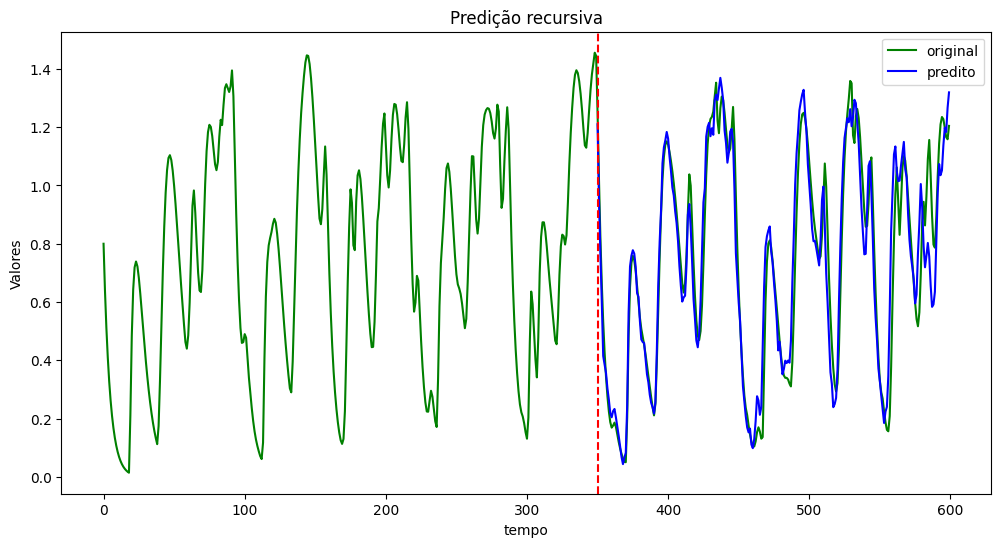

In [13]:
data2 =  datagen(qtd_amostras = 600)
split = 350
orig, pred = print_recursive(m, data2, split, step_ahead)

## Teste de hipótese (Teste de Kolmogorov)

Hipótese nula: Não existe diferença entre a função predita pelo modelo e a saída real.</br>
Hipótese alternativa: Existe uma diferença entre a função predita pelo modelo e saída real.

In [14]:
from scipy import stats
stats.ks_2samp(orig, pred)

KstestResult(statistic=np.float64(0.048), pvalue=np.float64(0.9363359992328345), statistic_location=np.float64(0.2122601462624083), statistic_sign=np.int8(1))

#### Interpretação

Assumindo um limiar de 5%, temos que como pvalue > 0.05, falhamos em rejeitar a hipótese nula. O parâmetro statistics nos diz que a diferença absoluta máxima é de 0.048. Conclusão: Os dados são representados pela mesma distribuição

## Plot quartil-quartil (Q-Q Plot)

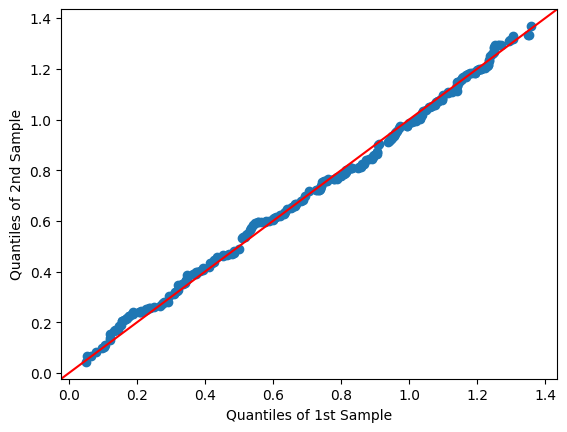

In [15]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(orig, pred, line="45")
plt.show()

#### Interpretação

Pelo gráfico, como segue a linha dos 45º, é possível inferir que as predições feitas pelo modelo pertencem à mesma distribuição dos dados originais, bem como é não é possível perceber a presença de outliers significativos. Portanto é possível inferir que temos um bom modelo

## Autocorrelação

In [16]:
from statsmodels.tsa.stattools import acf
ac_orig = acf(orig, fft=True)
ac_pred = acf(pred, fft=True)

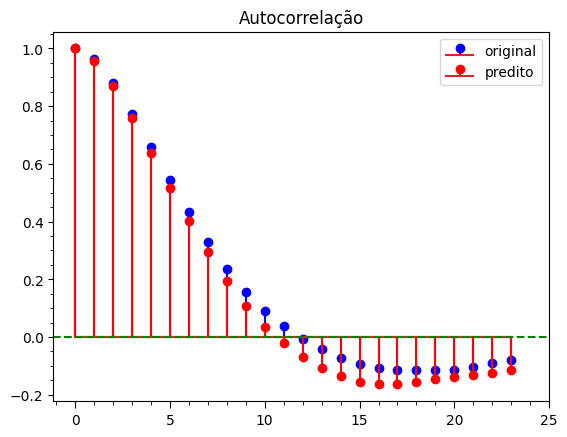

In [17]:
plt.figure()
plt.stem(ac_orig, linefmt = "b", label="original")
plt.stem(ac_pred, linefmt = "r", label="predito")
plt.axhline(y=0, color='g', linestyle='--')

plt.xticks(np.arange(0, 26, 5))
plt.tick_params(axis='x', which='major', length=5)
plt.minorticks_on()
plt.tick_params(axis='x', which='minor', length=3, labelsize=0)

plt.title("Autocorrelação") 
plt.legend()
plt.show()

#### Interpretação

Pelo gráfico de correlação é possível notar que tanto os dados oriundos do modelo quanto os dados originais possuem curvas de correlação bastante similares, o que significa que a dependência temporal dos dados (tanto modelo e reais) respondem de forma similar quando tratados em relação a si mesmos

Além disso, temos autocorrelação positiva até proximo de um lag de 10, o que significa que a série tende a seguir a mesma direção. A partir disso, a autocorrelação é levemente negativa implicando que os sinais tendem a ter mudança de direção.

## Erros quadraticos

In [35]:
def mse(pred, orig):
    return ((pred - orig)**2).mean(axis=0)

def eqmn(pred, orig, x_hat):
    u = np.array(orig).mean(axis=0)
    return mse(pred, orig)/(mse(x_hat, orig) + 1e-6)

In [37]:
#valor médio do processo
u = np.array(orig).mean(axis=0)
eqmn1 = eqmn(pred, orig, u)

#valor da amostra imediatamente anterior
x_hat_a = data2[split-1]
eqmn2 = eqmn(pred, orig, x_hat_a)

In [38]:
 print(f"EQMN1: {eqmn1:.4f} ,  EQMN2: {eqmn2:.4f}")

EQMN1: 0.1047 ,  EQMN2: 0.0222


#### Interpretação

Pelos dados, como EQMN1 << 1, é possível inferir que temos um preditor SUPERIOR a um preditor que apenas estime o valor futuro como o valor médio do processo

Também é possível inferir, como EQMN2 << 1, que temos um preditor SUPERIOR a um preditor que apenas estime o valor futuro como sendo igual ao valor imediatamente anterior ao processo.